# Processing raw counts

The following notebook shows how raw counts, i.e., counts returned form the backend, are converted into stabilizer values. Running this notebook will produce stabilizer values that will be displayed. These are the stabilizer values that can then be used to compute the witnesses. Note that each time we run this notebook we will get slightly different stabilizer values due to the stochastic nature of the resampling.

In [1]:
import json

from qiskit_experiments.framework import ExperimentDecoder

from analyze_raw_counts import LOAnalysis, LOCCAnalysis, StandardAnalysis
from result_processor import ResultProcessor
from cgs_result import CGSResult
from trex_manager import TREXManager
from cut_graph import CutGraph

In [2]:
decoder = ExperimentDecoder()

num_nodes = 103  # 103 or 134 to select the corresponding graph

cgs = CutGraph(f"{num_nodes}_node_graph.json")

with open(f"raw_data/{num_nodes}_node_graph_raw_data.json", "r") as infile:
    data = decoder.decode(json.load(infile))

#### Prepare counts with long-range gates implemented with LOCC

In [3]:
cgs_result = CGSResult.from_data(data=data["locc"], key_fields=LOCCAnalysis.KEY_FIELDS, creg_len=[num_nodes], creg_keys=["c"])

# Allows us to merge the TREX counts
processor = ResultProcessor(data["locc"]["__config__"]["_result_processor"]["trex_grouping"])
cgs_result = processor.trex_merge_results(cgs_result)

# Allows us to apply TREX mitigation
trex_manager = TREXManager(data["locc"]["__config__"]["trex_manager"]["calibration_counts"], num_nodes)

# Measured stabilizers according to their grouping
stabilizer_groups = decoder.decode(data["locc"]["__config__"]["stabilizer_groups"])

analyzer_locc = LOCCAnalysis(cgs_result, trex_manager, stabilizer_groups)

#### Prepare counts for the dropped edge benchmark

In [4]:
cgs_result = CGSResult.from_data(data=data["drop"], key_fields=StandardAnalysis.KEY_FIELDS, creg_len=[num_nodes], creg_keys=["c"])

# Allows us to merge the TREX counts
processor = ResultProcessor(data["drop"]["__config__"]["_result_processor"]["trex_grouping"])
cgs_result = processor.trex_merge_results(cgs_result)

# Allows us to apply TREX mitigation
trex_manager = TREXManager(data["drop"]["__config__"]["trex_manager"]["calibration_counts"], num_nodes)

# Measured stabilizers according to their grouping
stabilizer_groups = decoder.decode(data["drop"]["__config__"]["stabilizer_groups"])

analyzer_drop = StandardAnalysis(cgs_result, trex_manager, stabilizer_groups)

#### Prepare counts with long-range gates implemented with SWAPs

In [5]:
if "full" in data:
    cgs_result = CGSResult.from_data(data=data["full"], key_fields=StandardAnalysis.KEY_FIELDS, creg_len=[num_nodes], creg_keys=["c"])
    
    # Allows us to merge the TREX counts
    processor = ResultProcessor(data["full"]["__config__"]["_result_processor"]["trex_grouping"])
    cgs_result = processor.trex_merge_results(cgs_result)
    
    # Allows us to apply TREX mitigation
    trex_manager = TREXManager(data["full"]["__config__"]["trex_manager"]["calibration_counts"], num_nodes)
    
    # Measured stabilizers according to their grouping
    stabilizer_groups = decoder.decode(data["full"]["__config__"]["stabilizer_groups"])
    
    analyzer_swap = StandardAnalysis(cgs_result, trex_manager, stabilizer_groups)
else:
    analyzer_swap = None

#### Prepare counts with long-range gates implemented with LO

In [7]:
if num_nodes == 103:
    separate_jobs, job_task_metadata = False, [[{"zne_c": 1}] * 9]
else:
    separate_jobs, job_task_metadata = True, [[{"zne_c": 1}] * 96] * 9

cgs_result = CGSResult.from_data(
    data=data["lo"], 
    key_fields=LOAnalysis.KEY_FIELDS, 
    creg_len=[num_nodes, 2, 2], 
    creg_keys=["c", "lo1", "lo0"],
    job_task_metadata=job_task_metadata,
    separate_jobs=separate_jobs,
)

# Allows us to merge the TREX counts
processor = ResultProcessor(data["lo"]["__config__"]["_result_processor"]["trex_grouping"])
cgs_result = processor.trex_merge_results(cgs_result)

# Allows us to apply TREX mitigation
trex_manager = TREXManager(data["lo"]["__config__"]["trex_manager"]["calibration_counts"], num_nodes)

# Measured stabilizers according to their grouping
stabilizer_groups = decoder.decode(data["lo"]["__config__"]["stabilizer_groups"])

analyzer_lo = LOAnalysis(cgs_result, trex_manager, stabilizer_groups, cgs)

Compute the stabilizer values from the raw counts.

In [8]:
paulis = [pauli for group in stabilizer_groups for pauli in group]

In [9]:
stabilizers = {"locc": {}, "swap": {}, "drop": {}, "lo": {}}

for pauli in paulis:
    stabilizers["locc"][pauli] = analyzer_locc.mean_std(pauli, filters={"zne_c": 1})
    stabilizers["drop"][pauli] = analyzer_drop.mean_std(pauli)
    stabilizers["lo"][pauli] = analyzer_lo.mean_std(pauli)
    if analyzer_swap is not None:
        stabilizers["swap"][pauli] = analyzer_swap.mean_std(pauli)

In [10]:
from stabilizer_plotter import StabilizerPlotter

In [11]:
plotter = StabilizerPlotter(cgs)

In [12]:
order, _, _, _ = plotter.stabilizer_plot_order()
stab_map = {stab.to_label()[::-1].index("X"): stab for stab in cgs.stabilizers()}

In [13]:
import matplotlib.pyplot as plt

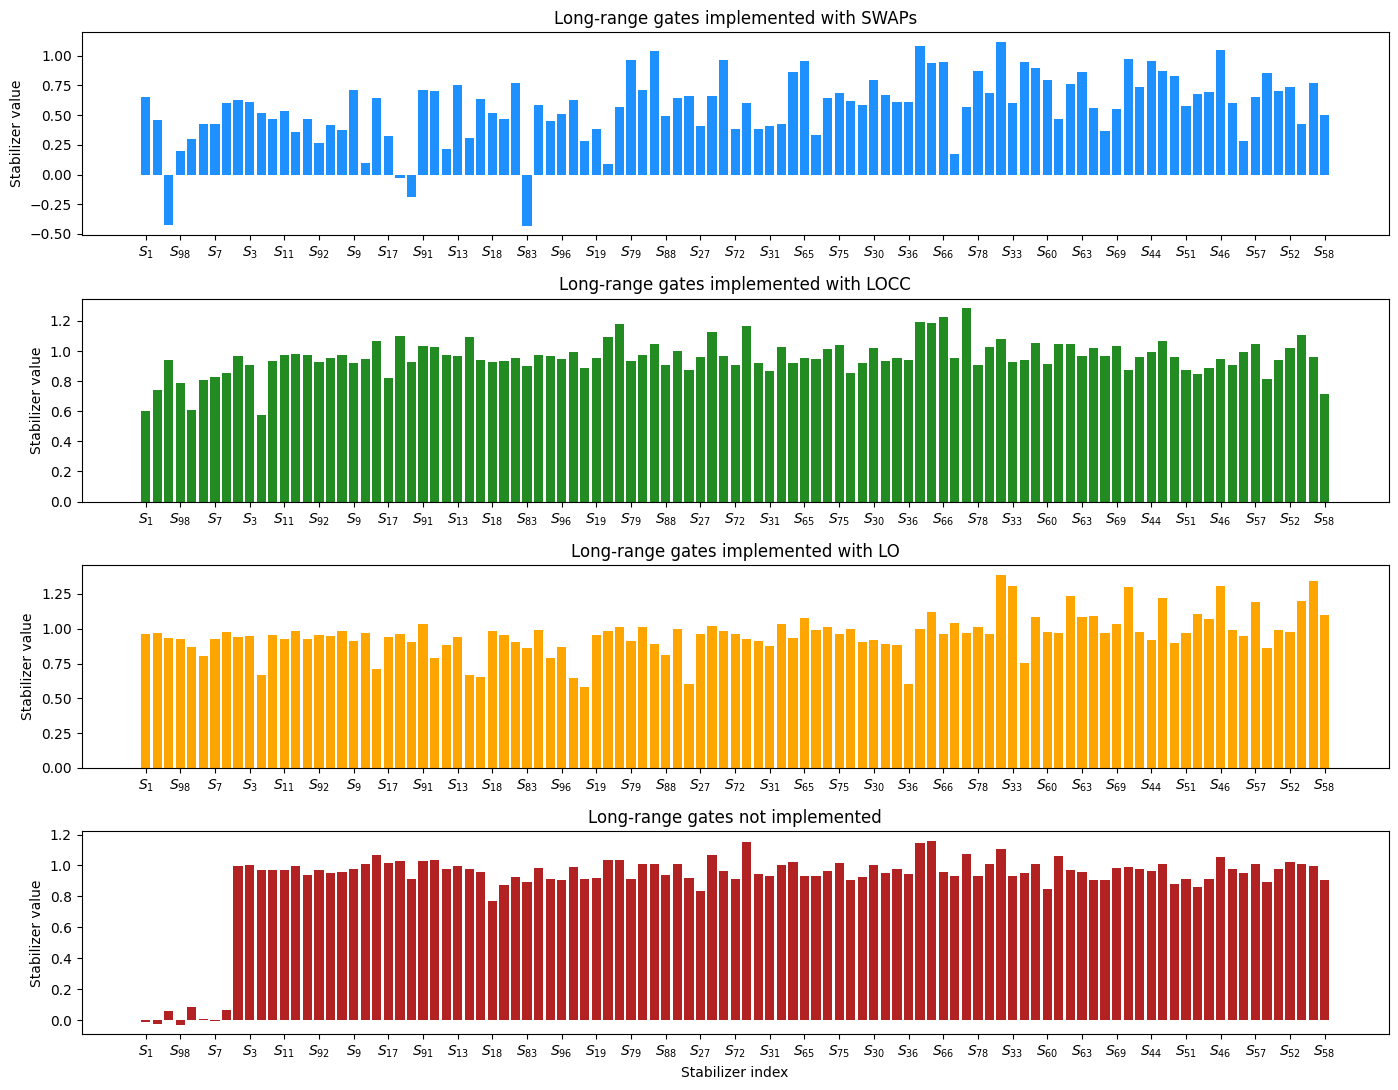

In [14]:
fig, axs = plt.subplots(4, 1, figsize=(14, 11))
if analyzer_swap is not None:
    axs[0].bar(range(num_nodes), [stabilizers["swap"][stab_map[idx]][0] for idx in order], color="dodgerblue")
axs[1].bar(range(num_nodes), [stabilizers["locc"][stab_map[idx]][0] for idx in order], color="forestgreen")
axs[2].bar(range(num_nodes), [stabilizers["lo"][stab_map[idx]][0] for idx in order], color="orange")
axs[3].bar(range(num_nodes), [stabilizers["drop"][stab_map[idx]][0] for idx in order], color="firebrick")
axs[0].set_title("Long-range gates implemented with SWAPs")
axs[1].set_title("Long-range gates implemented with LOCC")
axs[2].set_title("Long-range gates implemented with LO")
axs[3].set_title("Long-range gates not implemented")
axs[3].set_xlabel("Stabilizer index")
for ax in axs:
    ax.set_xticks(range(0, len(order), 3))
    ax.set_xticklabels(["$S_{" + f"{order[x]}" + "}$" for x in range(0, len(order), 3)]);
    ax.set_ylabel("Stabilizer value")
fig.tight_layout()